1. Extract the dataset

In [37]:
import zipfile
import os

zip_path = r"C:\Users\navas\Downloads\ser\Speech-Emotion-Recognition-with-Pytorch\archive.zip"
extract_path = r"C:\Users\navas\Downloads\ser\Speech-Emotion-Recognition-with-Pytorch\dataset"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted folders:", os.listdir(extract_path))


Extracted folders: ['TESS Toronto emotional speech set data']


 2. Set dataset path

In [38]:
DATASET_PATH = os.path.join(extract_path, "TESS Toronto emotional speech set data")
emotion_folders = os.listdir(DATASET_PATH)
print("Emotion Labels:", emotion_folders)

for emotion in emotion_folders:
    emotion_path = os.path.join(DATASET_PATH, emotion)
    print(f"{emotion}: {len(os.listdir(emotion_path))} files")


Emotion Labels: ['OAF_angry', 'OAF_disgust', 'OAF_Fear', 'OAF_happy', 'OAF_neutral', 'OAF_Pleasant_surprise', 'OAF_Sad', 'TESS Toronto emotional speech set data', 'YAF_angry', 'YAF_disgust', 'YAF_fear', 'YAF_happy', 'YAF_neutral', 'YAF_pleasant_surprised', 'YAF_sad']
OAF_angry: 200 files
OAF_disgust: 200 files
OAF_Fear: 200 files
OAF_happy: 200 files
OAF_neutral: 200 files
OAF_Pleasant_surprise: 200 files
OAF_Sad: 200 files
TESS Toronto emotional speech set data: 14 files
YAF_angry: 200 files
YAF_disgust: 200 files
YAF_fear: 200 files
YAF_happy: 200 files
YAF_neutral: 200 files
YAF_pleasant_surprised: 200 files
YAF_sad: 200 files


3. Plot a waveform and Spectrograms 

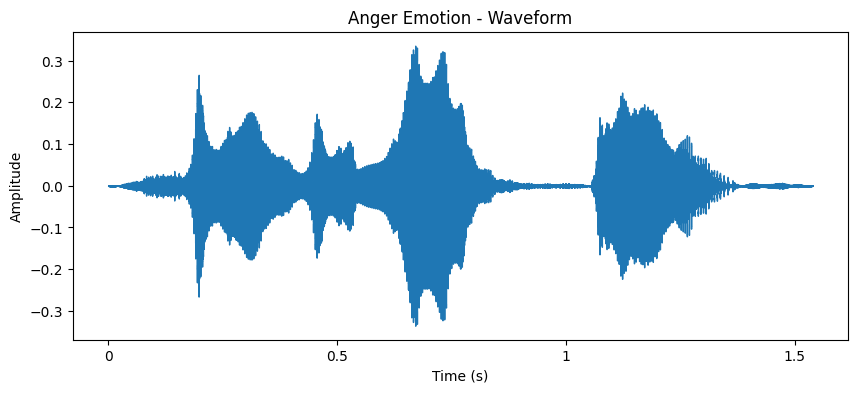

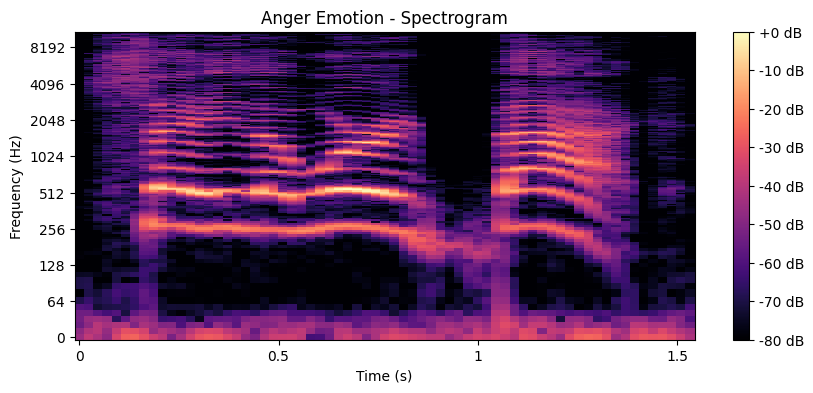

In [39]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Function to plot the waveform
def plot_waveform(y, sr, title="Waveform"):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

# Function to plot the spectrogram
def plot_spectrogram(y, sr, title="Spectrogram"):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

# Load the audio file
anger1 = os.path.join(DATASET_PATH, "OAF_angry", "OAF_back_angry.wav")
y, sr = librosa.load(anger1, sr=22050)

# Plot the waveform
plot_waveform(y, sr, title="Anger Emotion - Waveform")

# Plot the spectrogram
plot_spectrogram(y, sr, title="Anger Emotion - Spectrogram")


5. Extract features & labels


In [40]:
def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    y_trimmed, _ = librosa.effects.trim(y)
    mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
    return np.mean(mfccs.T, axis=0)

features, labels = [], []
for emotion_folder in emotion_folders:
    folder_path = os.path.join(DATASET_PATH, emotion_folder)
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            file_path = os.path.join(folder_path, file)
            features.append(extract_mfcc(file_path))
            labels.append(emotion_folder)


 6. Preprocess Data

In [41]:
from sklearn.preprocessing import StandardScaler

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

# Encode emotion labels to integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


7.Defines a Neural Network

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# Define the neural network model class
class NNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]  # Number of MFCC features (e.g., 13)
output_dim = len(label_encoder.classes_)  # Number of emotions (e.g., 7)

model = NNModel(input_dim, output_dim)


8.Train the Model

In [43]:
# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()  # Cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert training data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor)

    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [5/20], Loss: 2.5407
Epoch [10/20], Loss: 2.3972
Epoch [15/20], Loss: 2.2378
Epoch [20/20], Loss: 2.0555


9. Prediction - update file path

In [55]:
def predict_emotion(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs = np.mean(mfccs, axis=1)
    feature = scaler.transform([mfccs])
    feature_tensor = torch.tensor(feature, dtype=torch.float32)

    with torch.no_grad():
        output = model(feature_tensor)
        _, predicted_class = torch.max(output, 1)

    cleaned_emotion_labels = [label.split('_')[-1] for label in label_encoder.classes_]
    return cleaned_emotion_labels[predicted_class.item()]

# Example usage
test_file = os.path.join(DATASET_PATH, "YAF_angry", "YAF_back_angry.wav")
print(f"Predicted Emotion: {predict_emotion(test_file)}")


Predicted Emotion: angry


In [46]:
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Put the model in evaluation mode
model.eval()

# Disable gradient calculation for evaluation
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)  # Get the class with highest probability

    # Calculate accuracy
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 52.86%


In [54]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

DATASET_PATH = os.path.join(extract_path, "TESS Toronto emotional speech set data")
emotion_folders = os.listdir(DATASET_PATH)
print("Emotion Labels:", emotion_folders)

for emotion in emotion_folders:
    emotion_path = os.path.join(DATASET_PATH, emotion)
    print(f"{emotion}: {len(os.listdir(emotion_path))} files")


# Extract MFCC features from audio file
def extract_mfcc(file_path, sample_rate=22050, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=sample_rate)
    y_trimmed, _ = librosa.effects.trim(y)
    mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

# Load features and labels
features, labels = [], []
emotion_folders = os.listdir(DATASET_PATH)
for emotion_folder in emotion_folders:
    folder_path = os.path.join(DATASET_PATH, emotion_folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                features.append(extract_mfcc(file_path))
                labels.append(emotion_folder)

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

# Encode emotion labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the neural network model
class NNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

input_dim = X_train.shape[1]
output_dim = len(label_encoder.classes_)
model = NNModel(input_dim, output_dim)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Train the model
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate accuracy
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_test_tensor).sum().item()
    accuracy = correct / y_test_tensor.size(0)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Prediction function
def predict_emotion(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs = np.mean(mfccs, axis=1)
    feature = scaler.transform([mfccs])
    feature_tensor = torch.tensor(feature, dtype=torch.float32)

    with torch.no_grad():
        output = model(feature_tensor)
        _, predicted_class = torch.max(output, 1)

    cleaned_emotion_labels = [label.split('_')[-1] for label in label_encoder.classes_]
    return cleaned_emotion_labels[predicted_class.item()]

# Example prediction
sample_file = os.path.join(DATASET_PATH, "OAF_angry", "OAF_back_angry.wav")
print(f"Predicted Emotion: {predict_emotion(sample_file)}")



Emotion Labels: ['OAF_angry', 'OAF_disgust', 'OAF_Fear', 'OAF_happy', 'OAF_neutral', 'OAF_Pleasant_surprise', 'OAF_Sad', 'TESS Toronto emotional speech set data', 'YAF_angry', 'YAF_disgust', 'YAF_fear', 'YAF_happy', 'YAF_neutral', 'YAF_pleasant_surprised', 'YAF_sad']
OAF_angry: 200 files
OAF_disgust: 200 files
OAF_Fear: 200 files
OAF_happy: 200 files
OAF_neutral: 200 files
OAF_Pleasant_surprise: 200 files
OAF_Sad: 200 files
TESS Toronto emotional speech set data: 14 files
YAF_angry: 200 files
YAF_disgust: 200 files
YAF_fear: 200 files
YAF_happy: 200 files
YAF_neutral: 200 files
YAF_pleasant_surprised: 200 files
YAF_sad: 200 files
Epoch [5/30], Loss: 2.5741
Epoch [10/30], Loss: 2.4725
Epoch [15/30], Loss: 2.3364
Epoch [20/30], Loss: 2.1729
Epoch [25/30], Loss: 1.9873
Epoch [30/30], Loss: 1.7698
Test Accuracy: 70.18%
Predicted Emotion: angry
